# Kaggle project : State Farm Distracted Driver Detection
****
### Moumene K. AMROUCHE, 
### Vincent AUCONIE
### Ludovic MATAR
#### Supported by [Stéphane Gaïffas]
#### [University Paris 7]

## Table of contents
***

# I.Introduction <br>
###  1. The challenge
###  2. The Different approachs and proposed architectures
# II. Data loading
# III. First approach (VGG16 -NCNN)
### 1. Model
### 2. Results
# IV. Second approach (Efficient Net)
### 1. Model
### 2. Results
# V. Third approach (small CNN)
### 1. Model
### 2. Results

# I. Introduction

***

1.The challenge

The aim of our project is to propose some solutions to the 2016 kaggle challenge named State Farm Distracted Driver Detection.
Given some driver images taken inside their cars we would like to predict what they are doing.
As described on kaggle web page, the ten classes of behavior to predict are:



*  c0: safe driving
*  c1: texting - right
*  c2: talking on the phone - right
*  c3: texting - left
*  c4: talking on the phone - left
*  c5: operating the radio
*  c6: drinking
*  c7: reaching behind
*  c8: hair and makeup
*  c9: talking to passenger
 



2. The Different approachs and proposed architectures

We are given a dataset of 22 434 images taken by 26 drivers, each of them have several images of each class. We also have a csv dataset describing all those informations.

We chose to solve this challenge mainly with deep learning techniques.
In order to avoid over-fitting we chose to apply the data augmentation technique to our pictures. It will improve the performances of our networks.

Therefore, we used,  the random transformations we use contain horizontal flips, because images can contain rotations in practice and crop, so we can accentuate on some objects and to remove unwanted details/objects.

Our problem can be seen as an action recognition problem on still images, therefore we tried to apply some basics techniques used for those problems. 



We also tried to solve the given problem with the combination of a pretrained convolutional network and a classical machine learning algorithm as described in the article Action Recognition in Still Images using Residual Neural Network Features by Sreela S R, Sumam Mary Idicula. We chose a Resnet18 trained on ImageNet as a encoder. We withdrew the last 2048 fully connected layer. We can therefore extract vectors embedding of 512 units from the input images. We fed those extracted vectors to the input of a machine learning algorithm as a decoder. SVM with rbf kernel performed the best among Random forest and KNN with an accuracy of only 28%. </br>
Another technique we used was inspired by the article Deep Ensemble Learning for Human Action Recognition in Still Images proposed by Xiangchun Yu. We implemented a model in three part.The first part this a VGG16 wich is a combination of successive convolutional networks, in the second part we fed the output of this neural network to the inputs of three branches of convolutional neural networks. The third part is classifier of two hidden layer, both with 2048 units and a last output of 10 units.





# II. Data Loading

In [44]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null 
!pip install opencv-python-headless==4.1.2.30
!pip install pyyaml==5.4.1

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import nltk
from nltk.corpus import stopwords
import pickle
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from itertools import takewhile
import torchvision.datasets
import time
from sklearn import metrics
import plotly.express as px
import torch.utils.data as data
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os.path as osp
import cv2
import torch.nn.functional as F
import plotly
import psutil
import kaleido

In [44]:
!pip install pytorch-lightning

In [21]:
import pdb
import pytorch_lightning as pl
import torchmetrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#1 if google gpu is used
print(torch.cuda.device_count())

1


In [7]:
path_csv = 'data/state-farm-distracted-driver-detection/driver_imgs_list.csv'

In [8]:
path_csv = 'driver_imgs_list.csv'

In [9]:
df = pd.read_csv(path_csv)
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [10]:
labels = {f'c{j}':j for j in range(10)}
df['classname'] = df['classname'].map(labels)

Let's check some infos about drivers of our train+validation dataset

In [11]:
drivers = df.groupby('subject').groups.keys()
print('List of drivers id :\n', drivers)
print('\n\nNumber of unique drivers : ',len(drivers))
print("Average number of images per driver : ",round(df.groupby('subject').count()['classname'].mean()))

List of drivers id :
 dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


Number of unique drivers :  26
Average number of images per driver :  862


In [49]:
classes = sorted(df['classname'].unique())
dic_colors = {'0':'yellow', 
                  '1':'blue',
                  '2':'purple',
                  '3':'green',
                  '4':'grey',
                  '5':'brown',
                  '6': 'pink',
                  '7':'red',
                  '8':'orange', 
                  '9': 'black'
                  }


<function matplotlib.pyplot.show>

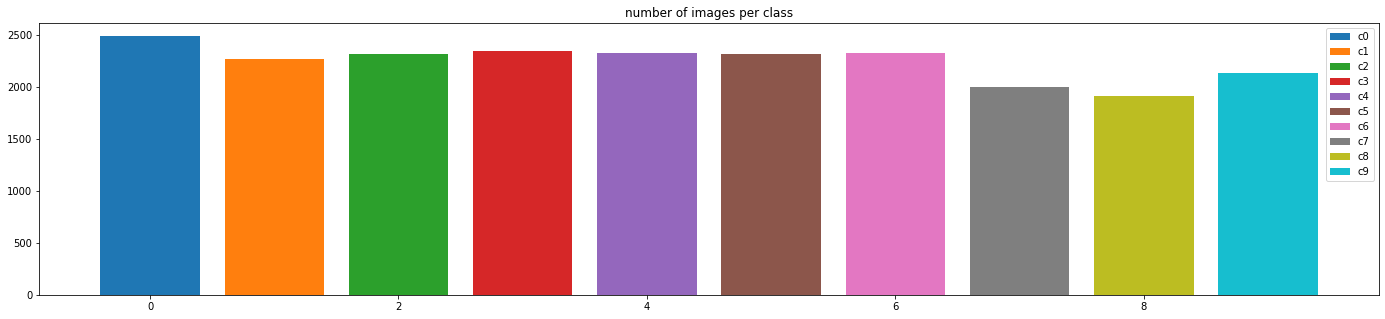

In [61]:
plt.figure(figsize=(24,5))
for clas in classes:
    dic = df[df['classname']==clas].shape[0]
    plt.bar(clas, dic, label=f'c{clas}')
plt.title('number of images per class')
plt.legend()
plt.show

We will split our dataset into two set, one for train and another for validation. In order to avoid over-fitting, drivers in the two set are not the same. We observe that we are happy to see that proportions of the different classes are roughly the same for datasets.

In [ ]:
drivers = df['subject'].unique()
train_drivers,test_drivers = train_test_split(drivers)
print('train drivers')
print(df[df['subject'].isin(train_drivers)]['classname'].value_counts(normalize=True))
print('\n')
print('test drivers')
print(df[df['subject'].isin(test_drivers)]['classname'].value_counts(normalize=True))

train drivers
0    0.115309
4    0.104160
3    0.103587
1    0.102631
5    0.102631
2    0.102504
6    0.102440
9    0.090845
7    0.089890
8    0.086004
Name: classname, dtype: float64


test drivers
3    0.107031
6    0.106585
2    0.105248
9    0.104504
5    0.104207
4    0.102720
0    0.100937
1    0.097517
7    0.087855
8    0.083395
Name: classname, dtype: float64


We create our own dataset because of the particular structure of the datas we have

In [13]:
class data_drivers:
    def __init__(self,path, dataframe, transform_=None):
        
        self.transform  = transform_

        self.label_paths = []

        drivers_set = dataframe['subject'].unique()
        for conducteur in drivers_set:
            conducteur_info = df[df['subject']==conducteur]
            way =  np.array([list(conducteur_info['classname'].values), list(conducteur_info['img'].values)])
            for j in range(len(way[0])):                  
                self.label_paths.append((int(way[0][j]), f'{path}/c{way[0][j]}/{way[1][j]}'))

        
       
    def __getitem__(self,idx):

        img = Image.open(self.label_paths[idx][1])

        
        label = self.label_paths[idx][0]
        label = label


        
        sample = {'image':img,'label':label}
        if self.transform:
            sample = {'image': self.transform(sample['image']), 'label':label}
        return sample

        return image,label
    def __len__(self):
        return len(self.label_paths)
        

In [14]:
import torch.nn.functional as F
class DataModule():

    def __init__(self,path, drivers, image_size: int = 224, batch_size: int = 128, num_workers: int = 2,
                 val_size: float = 0.2, **kwargs):
        
        #super().__init__()
        #self.data_dir = data_dir
        self.path = path
        self.transform_train = transforms.Compose([
            transforms.Resize((image_size + 4, image_size + 4)),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self.transform_test = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_size = val_size
        self.drivers = drivers

        self.dims = (3, image_size, image_size)

    def setup(self, stage: str = None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            train_drivers,test_drivers = train_test_split(self.drivers)
            df_train_drivers = df[df['subject'].isin(train_drivers)]
            df_test_drivers = df[df['subject'].isin(test_drivers)]
            
            self.dataset_train = data_drivers(path = self.path, dataframe = df_train_drivers, transform_=self.transform_train)
            self.dataset_test  = data_drivers(path = self.path, dataframe = df_test_drivers, transform_ = self.transform_test)

            #self.dataset_train, self.dataset_val = random_split(dataset, [len(dataset) - val_size, val_size])

        # Assign test dataset for use in dataloader(s)
        #if stage == 'test' or stage is None:
        #    self.dataset_test = ImageFolder(f"{self.data_dir}/val", transform=self.transform_test)

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

#Let's visualse our images

In [15]:
DD = data_drivers(path = './train', dataframe = df, transform_ = transforms.Compose([transforms.ToTensor()]))
loader_essai = DataLoader(DD, batch_size=1, shuffle=True, num_workers=2)

In [16]:
categories = ['safe driving',
'texting - right',
'talking on the phone - right',
'texting - left',
'talking on the phone - left',
'operating the radio',
'drinking',
'reaching behind',
'hair and makeup',
'talking to passenger']

In [17]:
len(categories)

10

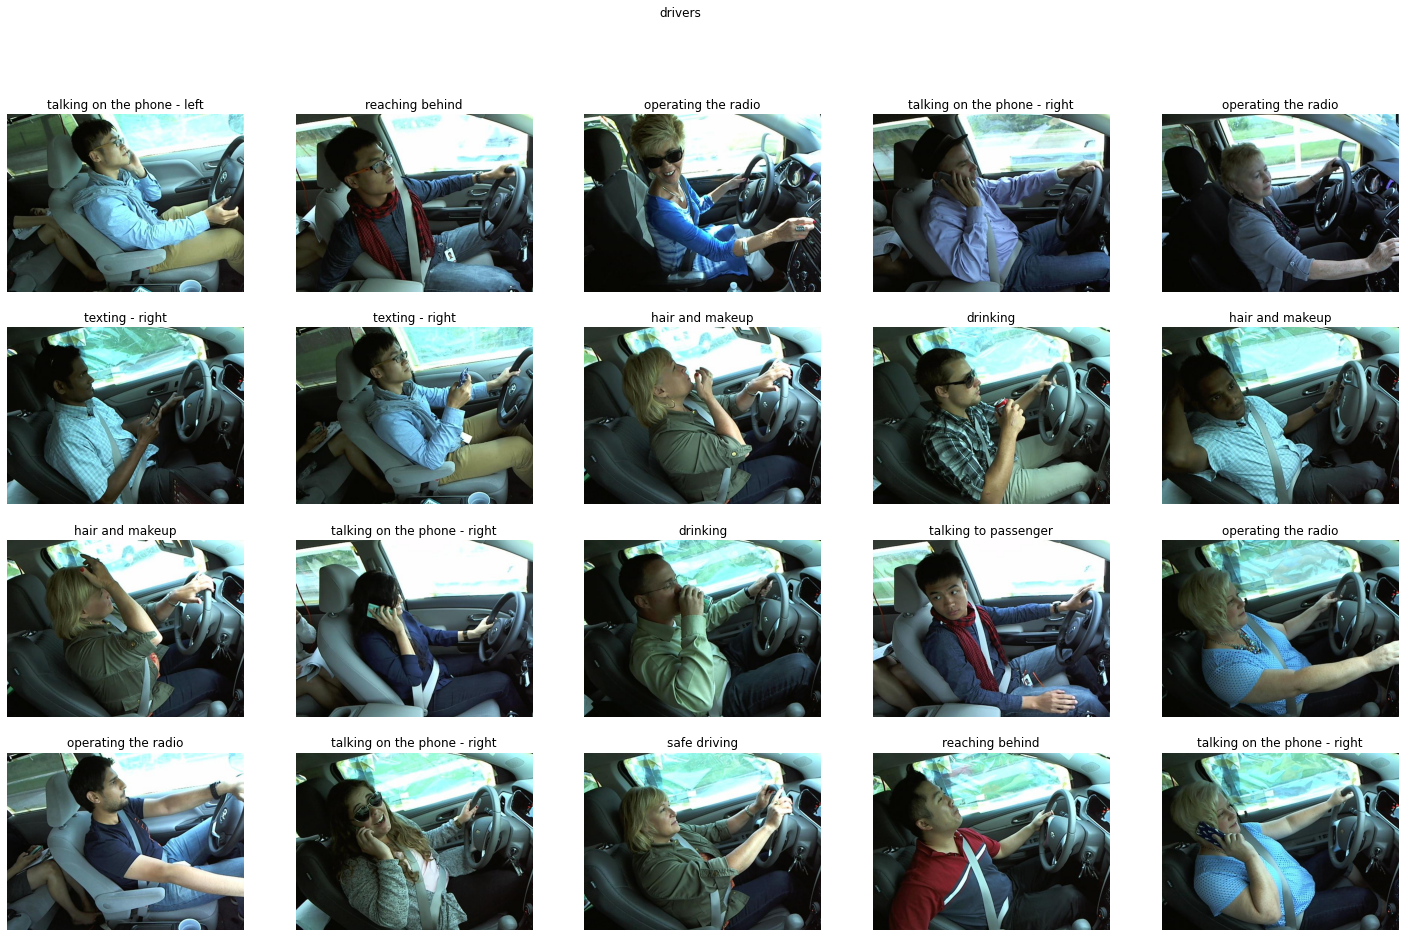

In [18]:
n_rows = 4
n_cols = 5

plt.figure(figsize=(25,15))
plt.suptitle('drivers')
for j,t in enumerate(loader_essai):
    if j == n_rows*n_cols:
        break
    img = t['image'][0]
    label = t['label'][0]
    img2 = img.permute(1,2,0).numpy() 
    ax = plt.subplot(n_rows, n_cols, 1+j)
    ax.imshow(img2)
    ax.set_title(label = categories[label])
    ax.axis('off')



# III. VGG16 -NCNN

We propose to implemented a model inspired by the article Deep Ensemble Learning for Human Action Recognition in Still Images (Xiangchun Yu). 
We use a VGG16 wich is a model used for image classification. This model is composed of four convolution layers and three fully connected layers. We take the first part of this network, we feed its output to multiple convolution layers used in parallel. Next, we gather the results into the input of two fully connected layers with 2048 units and a last one with 10 units, this last part can be seen as a majority vote. </br>
The VGG16 we use is pretrained with ImageNet. For the training we freeze the weights of the VGG, so its weights connot be impacted by the random initialized weights of the convulutional layers in parallel and the fully connected layers.
In order to reduce the requested memory of our GPU we decide to use batch of 20 elements. We trained this network for 10 only epochs, with adam solver and a learning rate of 0.0001. Finally, we obtained an accuracy of 85.18% for this model


In [22]:
class vgg_ncnn(pl.LightningModule):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        for param in vgg16.features.parameters():
            param.requires_grad = False
        mod = list(vgg16.children())[:-2][0]
        self.mod = nn.Sequential(*mod)
        #self.conv1_128 = nn.Conv2d(512, 128, kernel_size=(3,3), padding='same')
        A = nn.Sequential(nn.Conv2d(512, 128, kernel_size=(3,3), stride=1), nn.ReLU())
        B = nn.Sequential(nn.Conv2d(512, 128, kernel_size=(1,1), padding='same'),nn.ReLU(), nn.Conv2d(128,128, kernel_size = (3,3), stride=1), nn.ReLU())
        C = nn.Sequential(nn.AvgPool2d(kernel_size = (3,3), stride=1, padding=0),nn.Conv2d(512, 128, kernel_size=(1,1), padding='same'),nn.ReLU())
      
                
        self.N = nn.ModuleDict([['A',A] ,['B',B],['C',C]])

        self.fc1 = nn.Linear(9600, 2048, bias = True)
        self.fc2 = nn.Linear(2048,2048, bias = True)
        self.fc3 = nn.Linear(2048,10, bias = True)
        #self.paths = 
        
    def forward(self, x):
        x  = x.to(device)
        out = self.mod(x)
        out1 = self.N['A'](out)
        out2 = self.N['B'](out)
        out3 = self.N['C'](out)
        #print('out1', out1.shape,'out2',  out2.shape, 'out3', out3.shape)
        out = torch.stack([out1, out2, out3], dim=1).squeeze(0)
        out = torch.flatten(out, start_dim=0)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
      
        return out



In [23]:
model_vgg_cnn = vgg_ncnn().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

training loop:



```
# for epoch in range(num_epochs):
    print('epoch',epoch)
    for j,t in enumerate(train):
        batch = t['image']
        labels = t['label']
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = torch.empty(size=(batch.shape[0], 10)).to(device)
        for i,a in enumerate(batch):
            a = a.to(device)
            pred = model(a.unsqueeze(0))
            predictions[i] = pred
        
        
        loss = criterion(predictions,labels)
        
        
        if (j+1)%10 ==0:
            loss_plot.append(loss)

        loss.backward()
        optimizer.step()
        if (j+1)%50==0:
            print(f'Epoch : {epoch+1}/{num_epochs} step: {j+1}/{len(train)} Loss : {loss.item()}')  
```



In [26]:
drivers = df['subject'].unique()
datamodule = DataModule(path = './train',drivers = drivers, num_workers=2, batch_size=20)
datamodule.setup()
train = datamodule.train_dataloader()
test = datamodule.test_dataloader()
print(f'{len(train)} batch in train set')
print(f'{len(test)} batch in test set')
#print(f'total of {len(train)+ len(test)} pictures')

792 batch in train set
330 batch in test set


In [24]:
model_vgg_cnn.load_state_dict(torch.load('modelparam', map_location=device))

<All keys matched successfully>

In [ ]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach().to(device)
    for j,data in enumerate(loader):
        inputs, labels = data['image'], data['label']
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        if j%50==0:
            print(f'batch :{j}')
        #print(inputs.shape)
        pred = torch.empty(size=(inputs.shape[0], 10)).to(device)
        for i,a in enumerate(inputs):
            a = a.to(device)
            with torch.no_grad():
                  prediction = model(a.unsqueeze(0))
            pred[i] = prediction
        
        preds = pred.to(device)
            #preds = model(images)
        preds = preds.to(device)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [ ]:
predictions = get_predictions(model_vgg_cnn, test)
scores = F.softmax(predictions, dim=1)

batch :0
batch :50
batch :100
batch :150
batch :200
batch :250
batch :300


In [ ]:
torch.save(scores, 'scores.pt')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
all_label = torch.tensor([]).detach().to(device)
for j,a in enumerate(test):
    labels = a['label'].to(device)
    all_label = torch.cat((all_label, labels), dim=0)

In [ ]:
all_label.shape

torch.Size([6331])

In [ ]:
torch.save(all_label, 'all_label.pt')

In [ ]:
all_label = all_label.to('cpu').numpy()
scores = scores.to('cpu').numpy()

In [ ]:
print(np.shape(all_label))
print(np.shape(scores))

(6331,)
(6331, 10)


In [ ]:
all_label = all_label.astype(int)

In [ ]:
print(scores)

[[9.9989891e-01 2.3983131e-07 1.8203693e-07 ... 1.5910002e-06
  4.6078250e-07 1.7729817e-05]
 [9.9995732e-01 1.7316813e-07 9.8731618e-07 ... 4.9693722e-06
  1.5057174e-06 2.2369970e-05]
 [9.9976069e-01 2.0674202e-07 6.3646536e-07 ... 9.9711206e-06
  4.9743448e-06 1.8478876e-04]
 ...
 [5.6468298e-06 4.8944967e-05 7.0084418e-05 ... 7.6739711e-04
  7.5232291e-01 2.7642911e-03]
 [9.0425739e-05 7.1559090e-04 9.9384831e-04 ... 1.6411445e-03
  6.1446744e-01 1.5665101e-02]
 [2.4439438e-05 2.2566611e-04 7.9094758e-04 ... 3.9166250e-04
  1.4038636e-01 3.7500241e-03]]


In [ ]:
cm = confusion_matrix(all_label, np.argmax(scores, axis=1))
cm

array([[561,   0,   1,   4,  10,  20,   6,   0,  69,  55],
       [  2, 441,   0,   1,  30,  61,  75,   0,   2,  16],
       [  0,   1, 554,   0,  29,   0,  57,   0,  17,   0],
       [  0,   0,   0, 620,  25,   0,  10,   0,  16,   1],
       [  0,   0,   0,   0, 600,   0,   0,   0,  62,   0],
       [  1,   0,   0,   1,   0, 560,   4,   0,   2,  93],
       [  0,   3,   0,   1,   6,   0, 645,   0,   3,   2],
       [  0,   0,   0,   5,   0,   0,   1, 546,   9,   4],
       [  1,   9,  12,   3,   0,   2,  39,   2, 421,  11],
       [ 23,   4,   0,   0,   2,  48,  52,   0,  25, 445]])

In [ ]:
import scikitplot as skplt

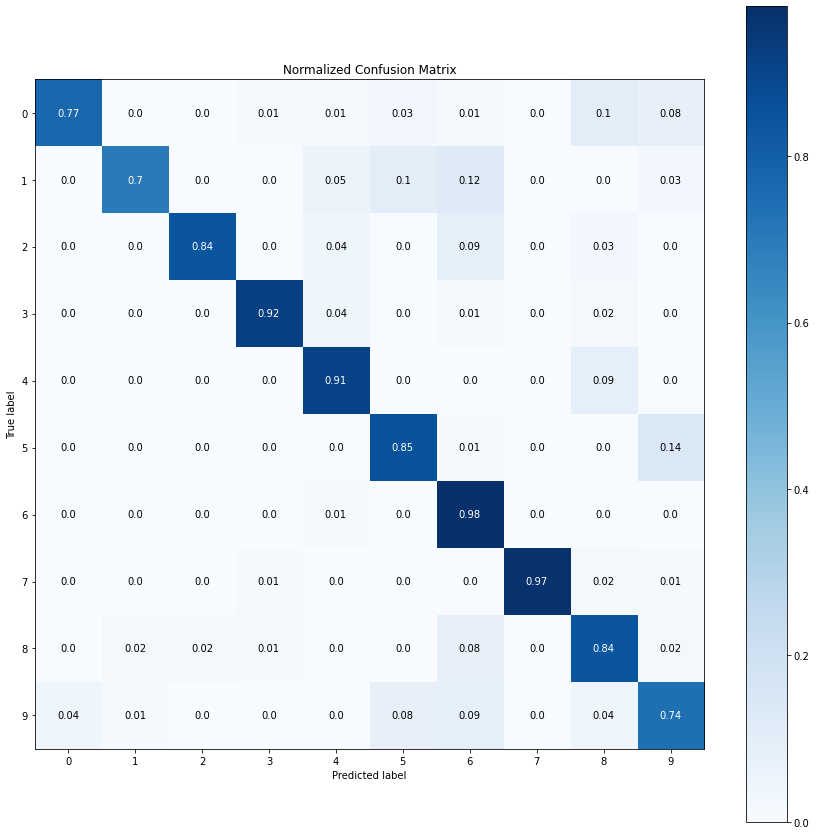

In [ ]:
skplt.metrics.plot_confusion_matrix(all_label,  np.argmax(scores, axis=1), normalize=True, figsize=(15, 15))
plt.savefig("conf_vgg_cnn.png")

We can examine how sensible is the model for the differents categories. Or model recognise best the categories 6 (drinking) and 7(reaching behind) but struggles with 0(safe driving), 1(text right) and 9(talking to passanger). Indeed, this two configuration for texting are different in the images.

In [ ]:
S = nn.Softmax(dim=1)
correct = 0
total = 0
with torch.no_grad():
    for j,data in enumerate(test):
        inputs, labels = data['image'], data['label']
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        pred = torch.empty(size=(inputs.shape[0], 10)).to(device)
        for i,a in enumerate(inputs):
            a = a.to(device)
            prediction = model_vgg_cnn(a.unsqueeze(0))
            pred[i] = prediction
        
        outputs = pred
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        if j%50==0:
          print('step', j)
        correct += (predicted == labels).sum().item()
    print("Test accuracy:{}%".format(100 * correct / total))

step 0
step 50
step 100
step 150
step 200
step 250
step 300
Test accuracy:85.18401516348128%


In [40]:
DD = data_drivers(path = './train', dataframe = df, transform_ =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]))
loader_essai = DataLoader(DD, batch_size=1, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

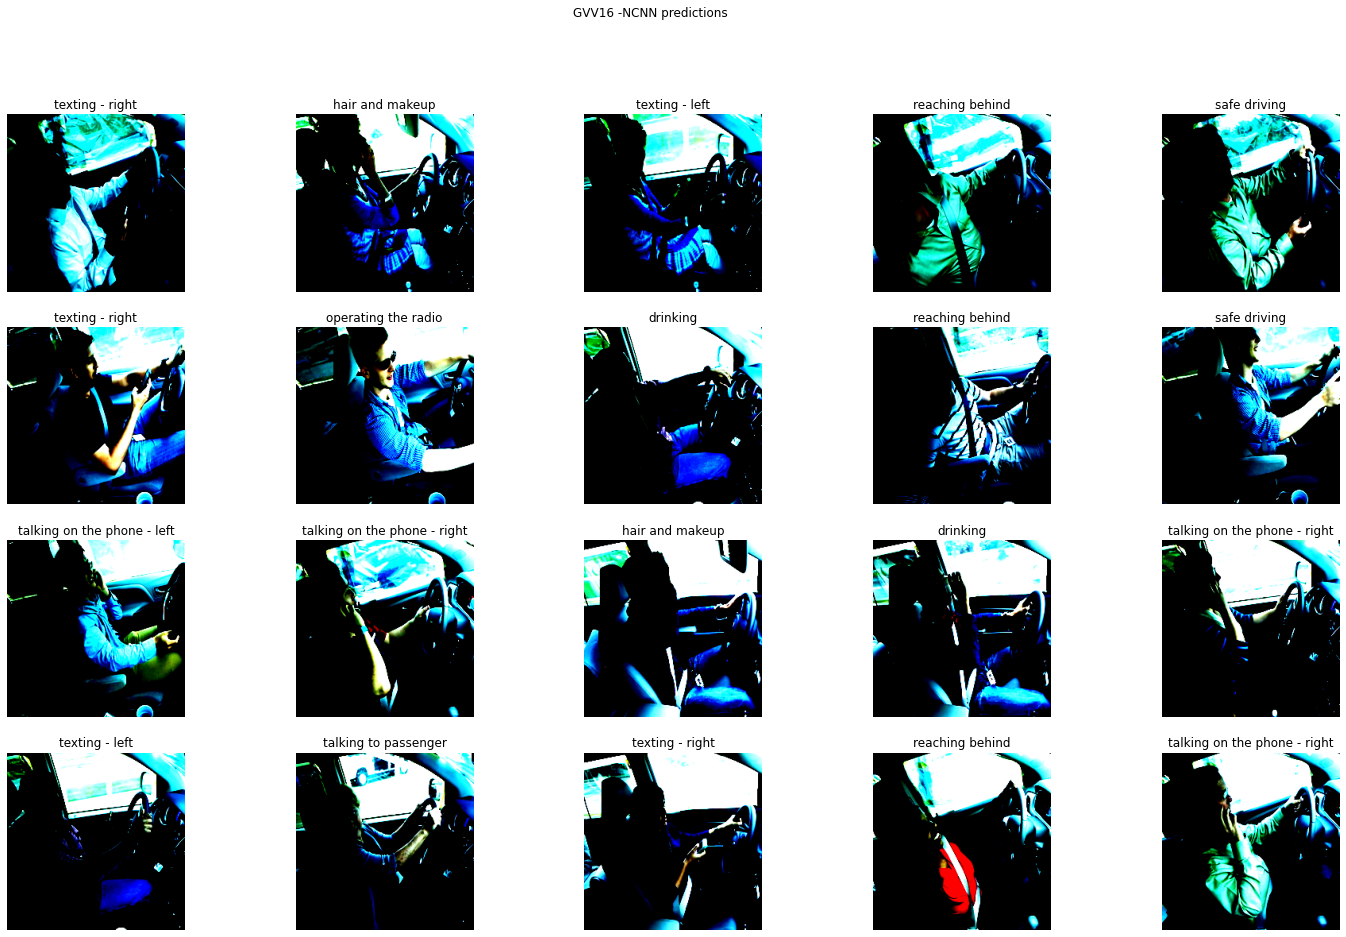

In [44]:
n_rows = 4
n_cols = 5

plt.figure(figsize=(25,15))
plt.suptitle('GVV16 -NCNN predictions')
for j,t in enumerate(loader_essai):
    if j == n_rows*n_cols:
        break
    img = t['image'][0]
    label = t['label'][0]
    output = model_vgg_cnn(img.unsqueeze(0))
    #print(output)
    _, predict_label = torch.max(output.data, 0)
    predict_label = int(predict_label.to('cpu'))
    img2 = img.permute(1,2,0).numpy() 
    ax = plt.subplot(n_rows, n_cols, 1+j)
    ax.imshow(img2)
    ax.set_title(label = categories[predict_label])
    ax.axis('off')
    
    

# IV. Efficient Net





In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_name('efficientnet-b1')
for param in model.parameters():
    param.requires_grad = True

In [ ]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()
model = model.to('cuda')
model

In [ ]:
%%time
# Train model
loss_log = []
i = 0
m = nn.Softmax(dim = 1)
for epoch in range(5):    
    model.train()    
    for ii, (data, target) in enumerate(datamodule.train_dataloader()):
        data, target = data.cuda(), target.cuda()
        target = target.float()                

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()  
        
        if ii % 1000 == 0:
            loss_log.append(loss.item())
       
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

We have tried to use a powerful transfert learning tool which is Efficient Net.
This kind of models optimise the architecture and help us to avoid models with more parameters than needed. We choosed Efficient Net b1, one of the most simple from this family. In addition the classifier is composed by a linear layer. It was crearly not the best model because of the time needed to train it, we were not able to train it within a reasonable amount of time. This is maybe due to the shape of our images and the size of the dataset.  

# V. Third approach

For our third approach, we decided to implement a "smaller" model with only 2 convolution blocks and by adding batch normalization. We also modified the initial transformation of our images and the type of data augmentation:

- **Normalization :** We decide this time to use a normalization of our channels more commonly used in this type of problem.

```
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
```

- **Data Augmentation :** In this model, we decided not to crop the image but to rotate it slightly and randomly to simulate a dashcam that could be oriented from a different angle.<br><br>

- **Trainer :** We also use the pl.Trainer tool to train our model directly unlike the previous model.

To implement this model, we were mainly inspired by articles directly related to the Kaggle State-farm challenge. (See sources)


In [ ]:
class model2(pl.LightningModule):
    def __init__(self):
        super(model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=4096, out_features=10)
        )
    
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        result = self.net(x)
        return result

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

On réimplémente une class pour la transformation de nos données ainsi que pour l'import des données dans le dataset. Contrairement au modèle précédent, nous allons ajouter à notre dataframe **df** une colonne **filepath** représentant le chemin d'accès au fichier pour ensuite importer nos image grâce à la fonction *imread* de la librairie *cv2*.

We reimplement a class for the transformation of our data as well as for the import of the data in the dataset. Contrary to the previous model, we will add to our dataframe **df** a **filepath** column representing the access path to the file and then import our images thanks to the *imread* function of the *cv2* library.

In [ ]:
class DataTransform():

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            

            'train': A.Compose([
                #data augmentation
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=15),
                A.Resize(input_size, input_size),
                
                #normalization of channels
                A.Normalize(color_mean, color_std),  
                ToTensorV2() 
            ]),
            'val': A.Compose([
                A.Resize(input_size, input_size),  
                A.Normalize(color_mean, color_std), 
                ToTensorV2() 
            ])
        }

    def __call__(self, phase, image):
      
        transformed = self.data_transform[phase](image=image)
        return transformed['image']

In [ ]:
class Dataset(data.Dataset):
    
    #phase = train or val
    def __init__(self, df, phase, transform):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):

        return len(self.df)

    def __getitem__(self, index):

        image = self.pull_item(index)
        return image, self.df.iloc[index]['class_num']

    def pull_item(self, index):
        
        # IMPORT OF IMAGES
        image_file_path = self.df.iloc[index]['filepath']
        image = cv2.imread(image_file_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.transform(self.phase, image)
        return image

In [ ]:
data_dir = 'state-farm-distracted-driver-detection'

## Separation of drivers

We separate the datasets so that we have NO drivers present in both the training and validation datasets.<br><br> At the end of this section, we will make a comparison between a model trained on a "well" separated dataset and a similar model trained on a dataset where drivers can be present in both train and val datasets.

In [ ]:
df_fp = pd.read_csv(osp.join(data_dir,'driver_imgs_list.csv'))
df_fp['filepath'] = df_fp.apply(lambda row: osp.join(data_dir, f"imgs/train/{row['classname']}/{row['img']}"), axis=1)
df_fp['class_num'] = df_fp['classname'].map(lambda x: int(x[1]))
drivers = df_fp['subject'].unique()
train_drivers,test_drivers = train_test_split(drivers)

df_train = df_fp[df_fp['subject'].isin(train_drivers)]
df_val = df_fp[df_fp['subject'].isin(test_drivers)]

df_train.head()

,subject,classname,img,filepath,class_num
0,p002,c0,img_44733.jpg,data/state-farm-distracted-driver-detection\im...,0
1,p002,c0,img_72999.jpg,data/state-farm-distracted-driver-detection\im...,0
2,p002,c0,img_25094.jpg,data/state-farm-distracted-driver-detection\im...,0
3,p002,c0,img_69092.jpg,data/state-farm-distracted-driver-detection\im...,0
4,p002,c0,img_92629.jpg,data/state-farm-distracted-driver-detection\im...,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example of an image after being transformed :


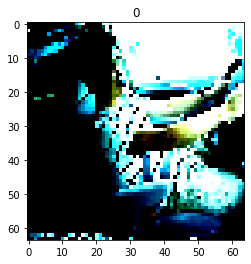

In [ ]:

color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = Dataset(df_train, phase="train", transform=DataTransform(
    input_size=64, color_mean=color_mean, color_std=color_std))

val_dataset = Dataset(df_val, phase="val", transform=DataTransform(
    input_size=64, color_mean=color_mean, color_std=color_std))

print("Example of an image after being transformed :")
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

We choose a batch_size of 64 because it proved to have better results during our training than smaller batch sizes.

In [ ]:
batch_size = 64

train_dataloader = None
val_dataloader = None

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
model_v2 = model2()

We use the *fast_dev_run* parameter of **pl.Trainer** to check that everything works before starting the training.

In [ ]:
trainer = pl.Trainer(gpus=0, progress_bar_refresh_rate=20, fast_dev_run=True)
trainer.fit(model_v2, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=1,default_root_dir="/content/drive/MyDrive/Colab Notebooks")
trainer.fit(model_v2, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning:

Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning:

`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | net      | Sequential | 52.2 K
1 | accuracy | Accuracy

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Results

**a)** First, we will display some predictions on unlabeled images from our *test* folder.

**b)** After that, we will display the confusion matrix of our model on the validation dataset to observe the results of this model.


In [ ]:
saved_model_good_split = model2.load_from_checkpoint(checkpoint_path="epoch=9-step=2689.ckpt")

In [ ]:
saved_model_bad_split = model2.load_from_checkpoint(checkpoint_path="epoch=9-step=2629.ckpt")


## 1 - With good separation of drivers :

In [ ]:
#some test image without label
image_list = ['data/state-farm-distracted-driver-detection/imgs/test/img_46.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_47.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_17846.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_17888.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_778.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_779.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_780.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_781.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_782.jpg',
 'data/state-farm-distracted-driver-detection/imgs/test/img_783.jpg']

In [ ]:
def load_image(image_path, input_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([input_size, input_size], Image.LANCZOS)
    return image


def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    return image_tensor

def show_images(img):
    plt.figure(figsize=(32, 32))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach().to(device)
    for j,data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        if j%50==0:
            print(f'batch :{j}')
        #print(inputs.shape)
        pred = torch.empty(size=(inputs.shape[0], 10)).to(device)
        for i,a in enumerate(inputs):
            a = a.to(device)
            with torch.no_grad():
                  prediction = model(a.unsqueeze(0))
            pred[i] = prediction
        
        preds = pred.to(device)
            #preds = model(images)
        preds = preds.to(device)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [ ]:
predictions = get_predictions(saved_model_good_split, val_dataloader)
scores = F.softmax(predictions, dim=1)

all_label = torch.tensor([]).detach().to(device)
for j,a in enumerate(val_dataloader):
    _, labels = a
    all_label = torch.cat((all_label, labels), dim=0)
    
all_label = all_label.to(device).numpy()
scores = scores.to(device).numpy()    

cm = confusion_matrix(all_label, np.argmax(scores, axis=1))
cm

batch :0
batch :50
batch :100


array([[747,   1,   0,   0,   0,   0,   0,   0,  30,   1],
       [ 35, 522,   5,   4,   0,   0,   0,   0, 117,   3],
       [  0,   1, 561,   0,   0,   0,  47,   0,  72,   0],
       [ 59,   0,   0, 515,   2,   2,   0,   0, 100,   1],
       [ 10,   0,   3,   3, 505,  10,   0,   1, 150,   0],
       [  4,   0,   3,   0,   0, 600,   0,   0,  77,   1],
       [  0,   3,   3,   1,   1,  19, 502,   0, 162,   0],
       [  9,   1,   6,   1,   9,   5,   0, 445, 104,   0],
       [ 12,   0,   6,   7,   0,   5,   2,  12, 485,   4],
       [ 87,   7,   6,   0,   0,   1,   0,   0,  10, 528]], dtype=int64)

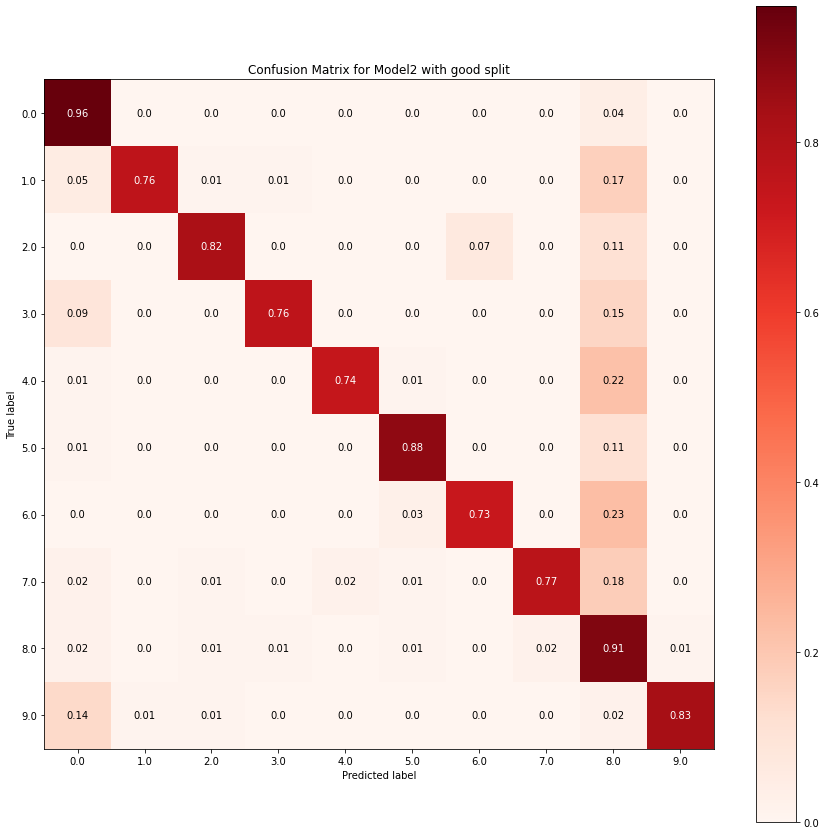

In [ ]:
skplt.metrics.plot_confusion_matrix(all_label,  np.argmax(scores, axis=1), normalize=True, figsize=(15, 15)
                                   ,title ='Confusion Matrix for Model2 with good split', cmap='Reds')
plt.savefig("model_2_v1.png")

## 2 - With bad separation of drivers :

In [ ]:
#DEVICE : 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predictions = get_predictions(saved_model, val_dataloader)
scores = F.softmax(predictions, dim=1)


In [ ]:
all_label = torch.tensor([]).detach().to(device)
for j,a in enumerate(val_dataloader):
    _, labels = a
    all_label = torch.cat((all_label, labels), dim=0)
    
all_label = all_label.to(device).numpy()
scores = scores.to(device).numpy()    

In [ ]:
cm = confusion_matrix(all_label, np.argmax(scores, axis=1))
cm

array([[771,   0,   0,   0,   0,   2,   2,   2,   0,   2],
       [  1, 677,   0,   0,   0,   0,   3,   0,   2,   3],
       [  3,   0, 659,   0,   0,   0,  14,   1,   1,   3],
       [  5,   0,   5, 667,   0,   0,   0,   0,   2,   0],
       [ 11,   0,   0,   2, 661,   3,   1,   0,   2,   2],
       [  1,   0,   0,   0,   0, 683,   0,   0,   0,   1],
       [  1,   1,   1,   0,   0,   0, 687,   0,   1,   0],
       [  2,   0,   0,   0,   0,   1,   0, 572,   5,   0],
       [ 24,   7,   1,   1,   4,   9,  13,  36, 406,  32],
       [  1,   0,   0,   0,   0,   2,   0,   1,   1, 634]], dtype=int64)

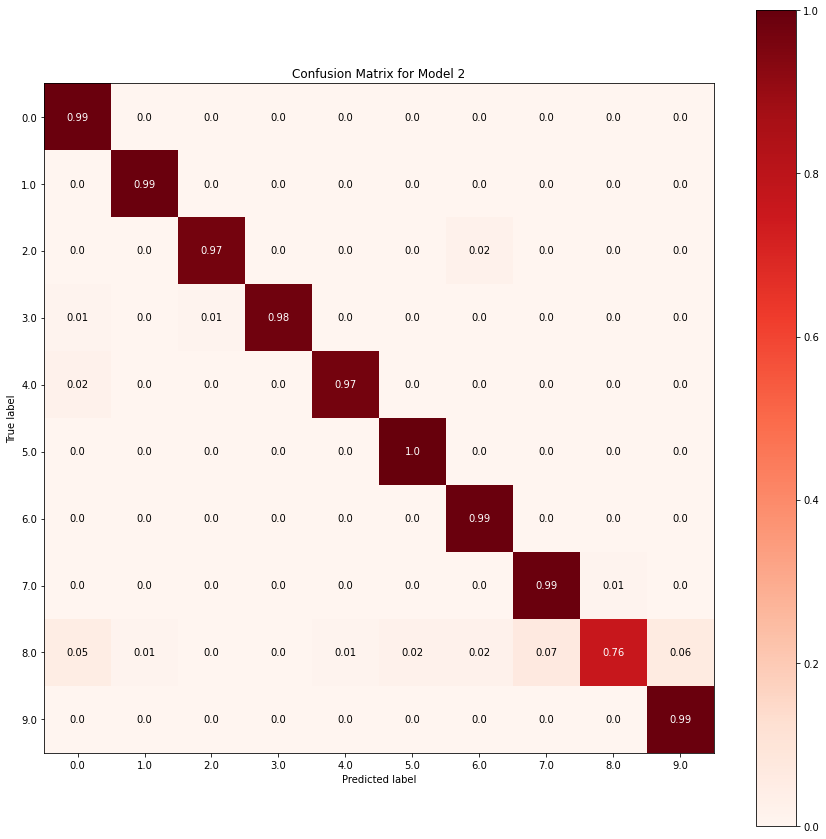

In [ ]:
skplt.metrics.plot_confusion_matrix(all_label,  np.argmax(scores, axis=1), normalize=True, figsize=(15, 15)
                                   ,title ='Confusion Matrix for Model 2', cmap='Reds')
plt.savefig("model_2_v2.png")

## Observations :

- We clearly observe very accurate results on the model predictions on the validation dataset when the separation of the drivers so that no driver is in the 2 datasets has not been done. 
    This is a logical observation because our dataset has several images of each driver in each position which creates very similar images between the training and validation dataset.<br><br>
    
- Another modification that could have been considered in the construction of the model is to remove the horizontal symmetry that we performed with a probability of 0.5 to possibly accentuate the recognition of symmetrical classes (left hand / right hand)


# Conlusion
***



After different readings and tests of models, we have kept 3 models to represent and describe the variations in the search for our parameters but also in the search for the model. Our first approach presents the best accuracy on the validation dataset with an average percentage of 85%. The use of the pre-trained VGG16 model allowed us to save time on the training.<br><br>

We then tried to model an architecture without using a pre-trained model (third approach) and we started with a simpler model that uses CNN blocks and with a faster training allowed us to optimize the choice of some hyper-parameters and the pre-processing of our images.

# References:

#### 1 [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)

#### 2 [Action Recognition in Still Images using Residual Neural Network Features](https://www.sciencedirect.com/science/article/pii/S1877050918321306?fbclid=IwAR0YBacKm1Qn4iqMuojcs1NbQS8p5oxXaJnE62OvAcqEpZUOCwDeB8cF7cc)


#### 3 [Deep Ensemble Learning for Human Action Recognition in Still Images](https://www.hindawi.com/journals/complexity/2020/9428612/)


#### 4 [Writing a Custum dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

#### 5 [Articles & Works related to this challenge](https://www.kaggle.com/seele1917/state-farm-distracted-driver-detection-practice/notebook)